## Create CNN Model and optimize using Keras Tuner

In [1]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.5 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

### Download the dataset and create test and train images

In [4]:
fashion_mnist = keras.datasets.fashion_mnist

In [5]:
(train_images , train_labels) , (test_images , test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


### Scale images between 0 and 1 

In [6]:
train_images = train_images/255.0
test_images = test_images/255.0

In [10]:
train_images[0].shape

(28, 28, 1)

### Reshape the train and test images

In [9]:
train_images = train_images.reshape(len(train_images) , 28 , 28 , 1)
test_images = test_images.reshape(len(test_images) , 28 , 28 , 1)

### Create function to build the model

In [12]:
def build_model(hp):  
  model = keras.Sequential([
      # Input layer
    keras.layers.Conv2D(
        #create range of integers with min value 32 , max value 128
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        # kernel size is the filter size and can be choice between 3*3 and 5*5 as specified in the below line of code
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        # Image shape which we pass to the model
        input_shape=(28,28,1)
    ),
    # Layer 2
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    # Dense layer requires input in single-dimensional shape i.e. 1-D array which is why we use Flatten()
    keras.layers.Flatten(),
    # Dense Layer is simple layer of neurons in which each neuron receives input from all the neurons of previous layer, thus called as dense. Dense Layer is used to classify image based on output from convolutional layers.
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    # softmax function is used as it is good for multiclass classification
    keras.layers.Dense(10, activation='softmax')
  ])
  
  # Adam optimizer used  , learning rate choices and loss for multi classification used sparse categorical cross entropy
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [15]:
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [17]:
tuner_search = RandomSearch(build_model , objective = 'val_accuracy' , max_trials = 5 , directory = "output" , project_name = 'Mnist Fashion')

### Best Hyperparameters finding

In [19]:
tuner_search.search(train_images , train_labels, epochs = 3 , validation_split = 0.1)

Trial 5 Complete [00h 00m 42s]
val_accuracy: 0.8633333444595337

Best val_accuracy So Far: 0.9128333330154419
Total elapsed time: 00h 02m 54s


### Take best hyperparameters for model

In [20]:
model = tuner_search.get_best_models(num_models=1)[0]

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 128)       1280      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 48)        55344     
                                                                 
 flatten (Flatten)           (None, 27648)             0         
                                                                 
 dense (Dense)               (None, 48)                1327152   
                                                                 
 dense_1 (Dense)             (None, 10)                490       
                                                                 
Total params: 1,384,266
Trainable params: 1,384,266
Non-trainable params: 0
_________________________________________________________________


### Fit the model on train images and train labels

In [26]:
history = model.fit(train_images, train_labels, epochs=10, validation_split=0.1, initial_epoch=3)

Epoch 4/10
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0255 - accuracy: 0.9911 - val_loss: 0.4940 - val_accuracy: 0.9083
Epoch 5/10
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0182 - accuracy: 0.9939 - val_loss: 0.5763 - val_accuracy: 0.9102
Epoch 6/10
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0200 - accuracy: 0.9928 - val_loss: 0.6071 - val_accuracy: 0.9070
Epoch 7/10
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0147 - accuracy: 0.9951 - val_loss: 0.6559 - val_accuracy: 0.9103
Epoch 8/10
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0177 - accuracy: 0.9939 - val_loss: 0.6966 - val_accuracy: 0.9150
Epoch 9/10
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0154 - accuracy: 0.9951 - val_loss: 0.7436 - val_accuracy: 0.9117
Epoch 10/10
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0148 - accuracy: 0.9950 - val_loss: 0.6728 - val_accuracy

### Evaluate the model

In [24]:
import matplotlib.pyplot as plt

313/313 - 1s - loss: 0.7060 - accuracy: 0.9071 - 916ms/epoch - 3ms/step


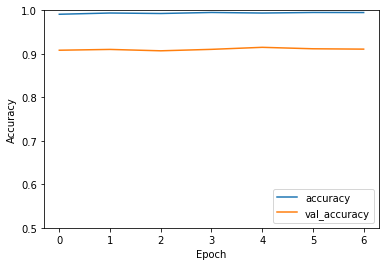

In [27]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [28]:
print(test_acc)

0.9071000218391418
